# 03 - Exploratory Data Analysis (EDA)



## Objective
Explore distributions, imbalance, correlations, and sensor behavior. Produce diagnostic plots.

---

### Run order
Execute notebooks in numeric order: 01 → 02 → 03 → 04 → 05. Each notebook mounts Google Drive and reads/writes intermediate artifacts so it can run independently.

---


Drive already mounted!
Loaded preprocessed: (166441, 54)


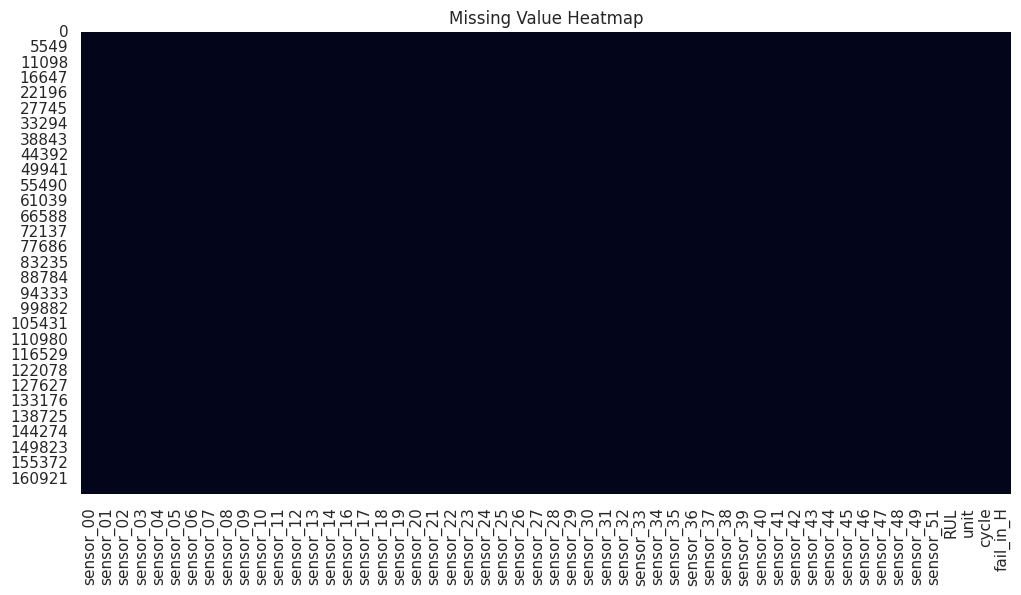

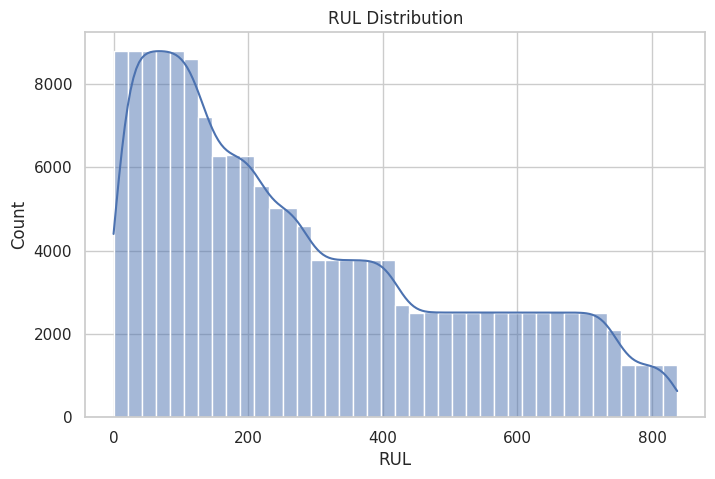

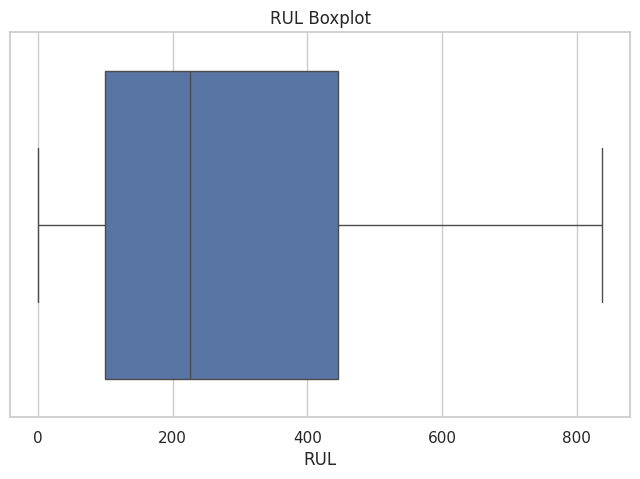

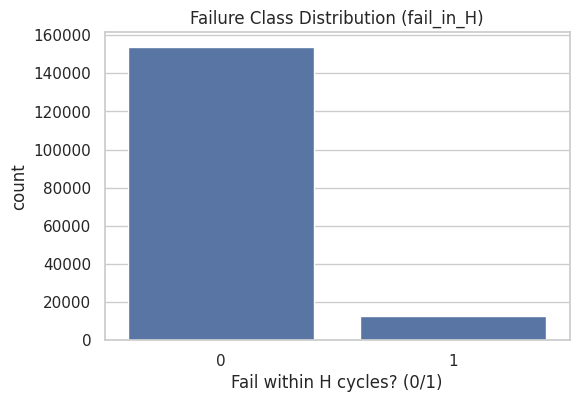

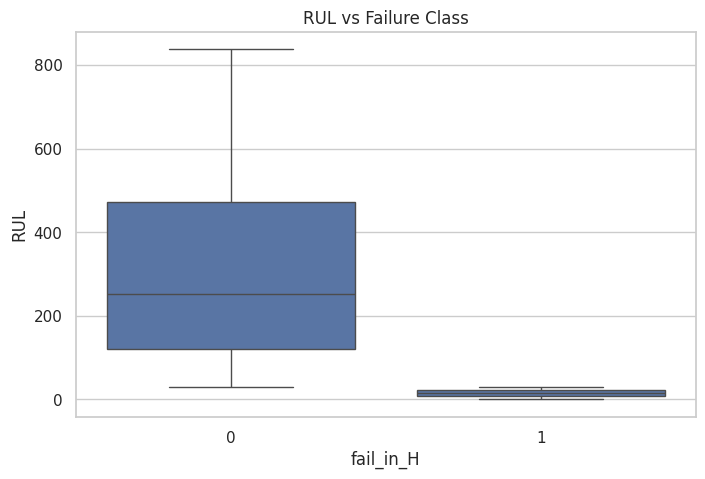

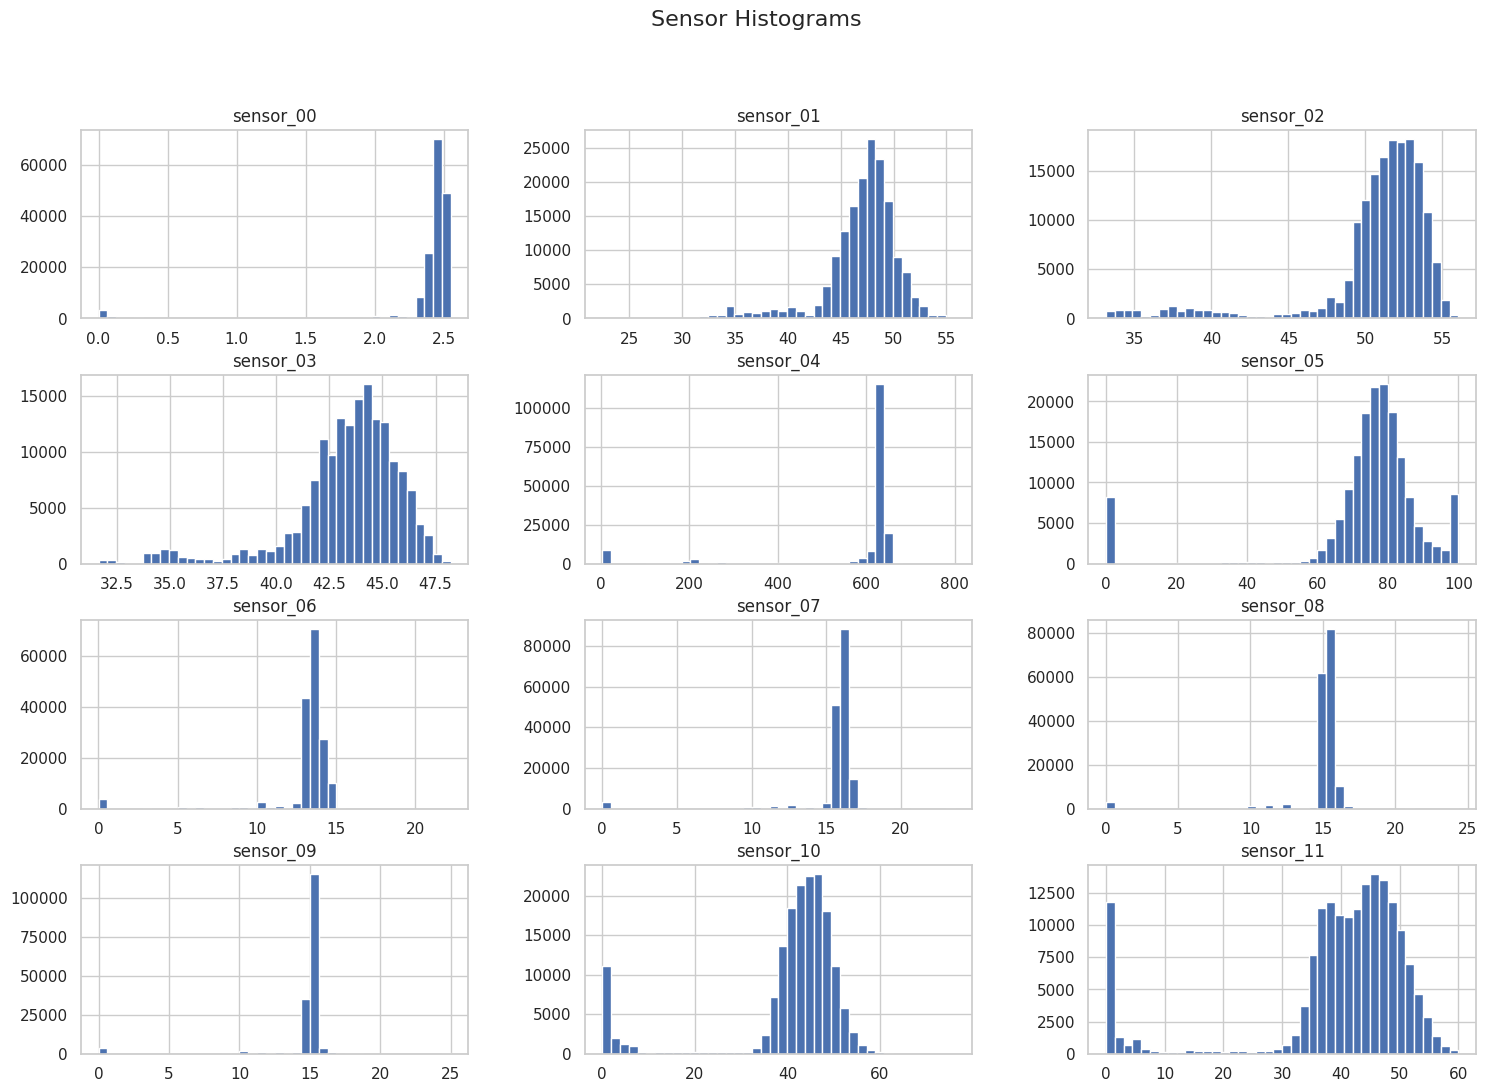

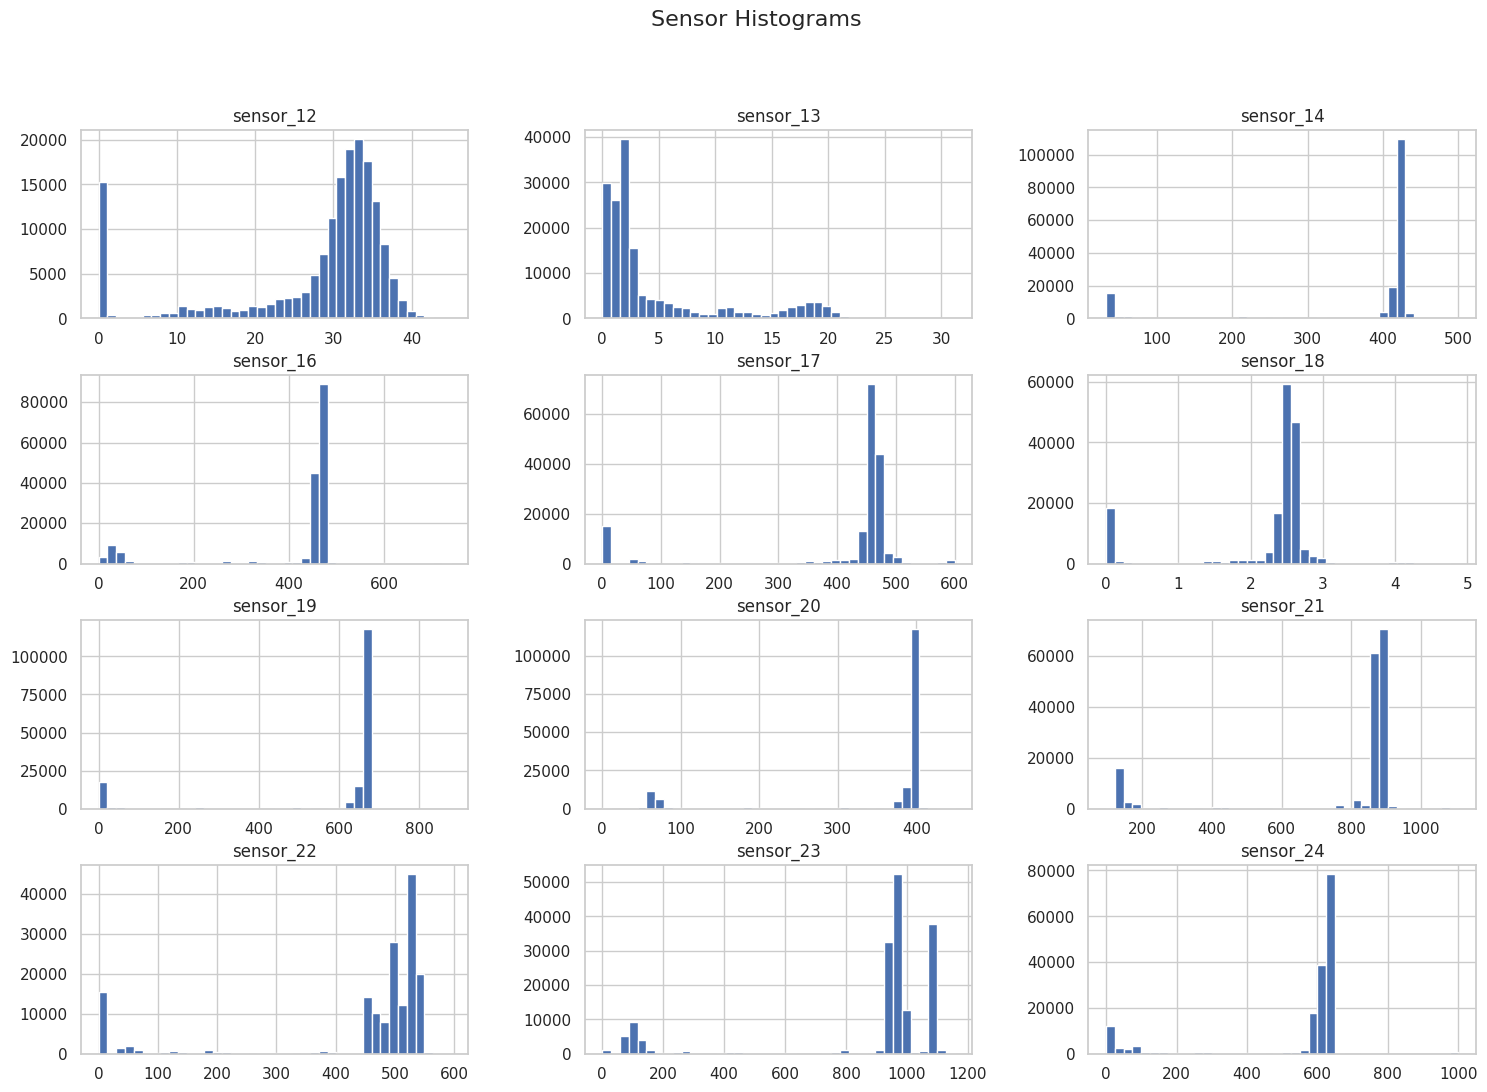

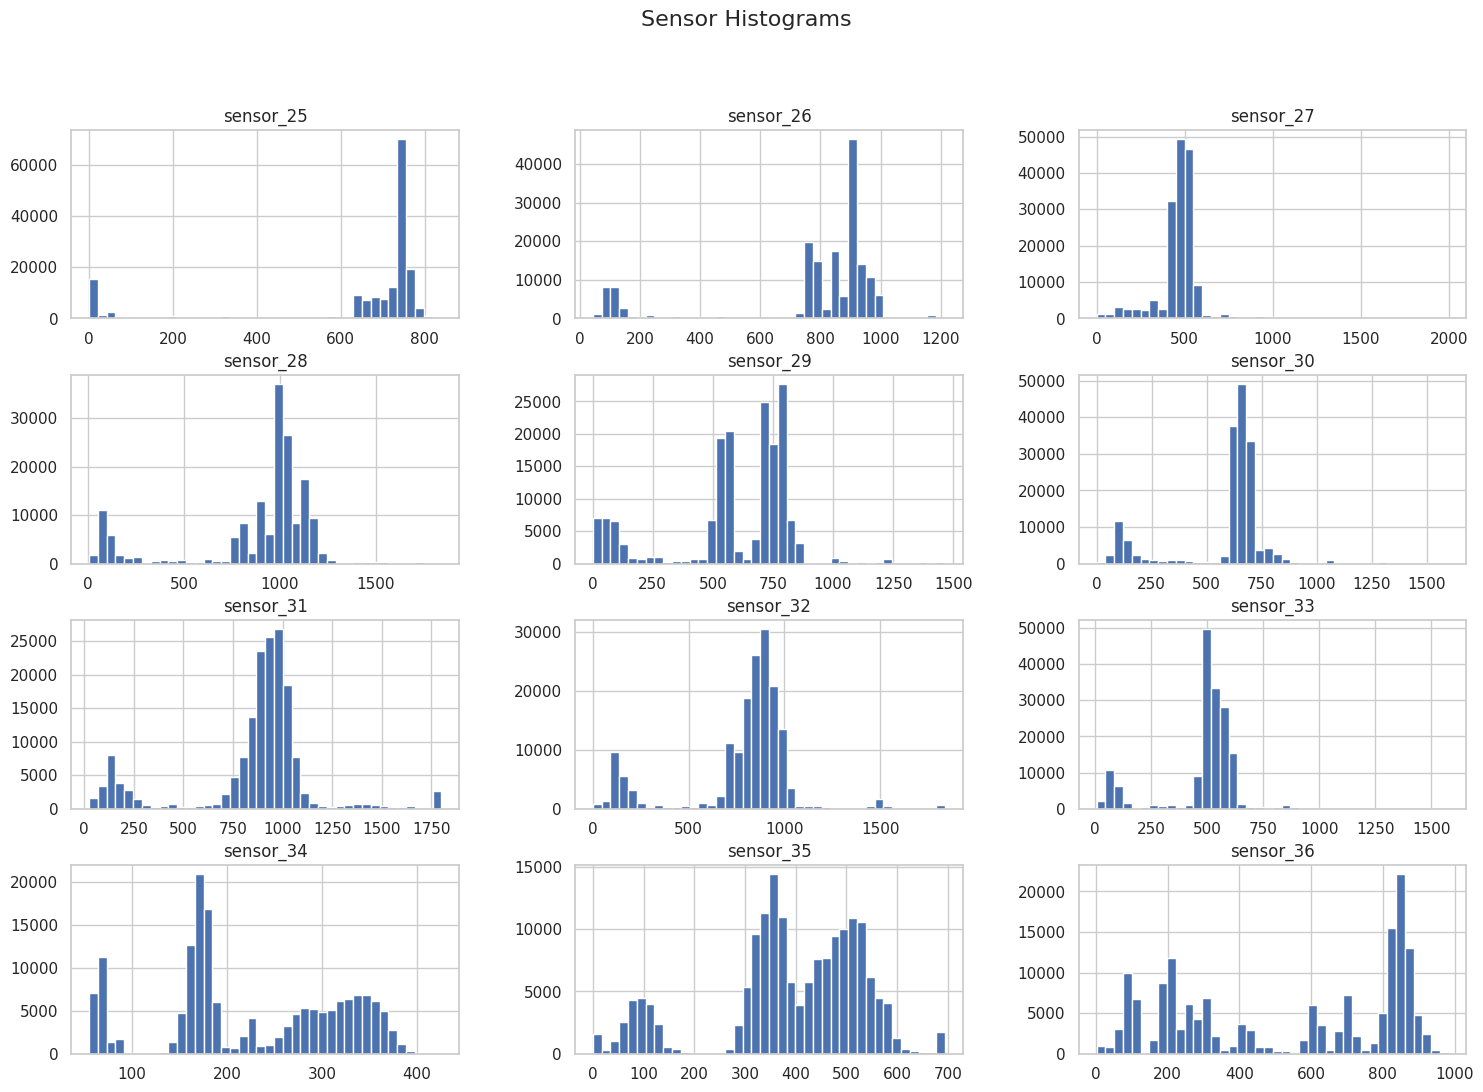

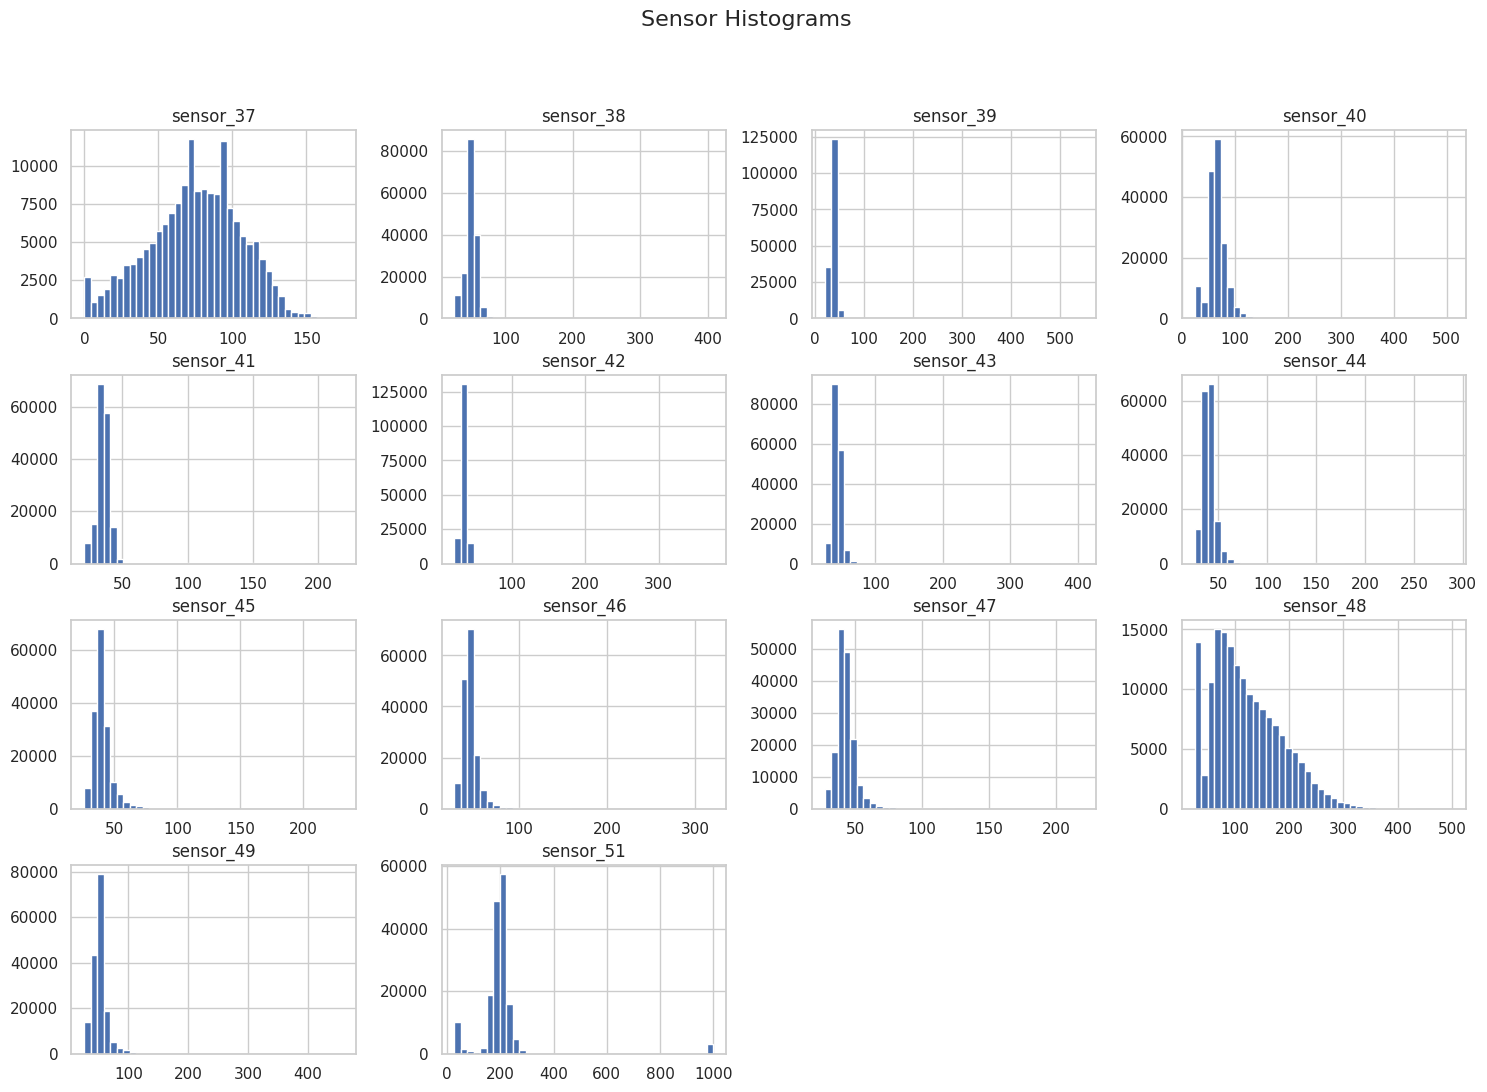

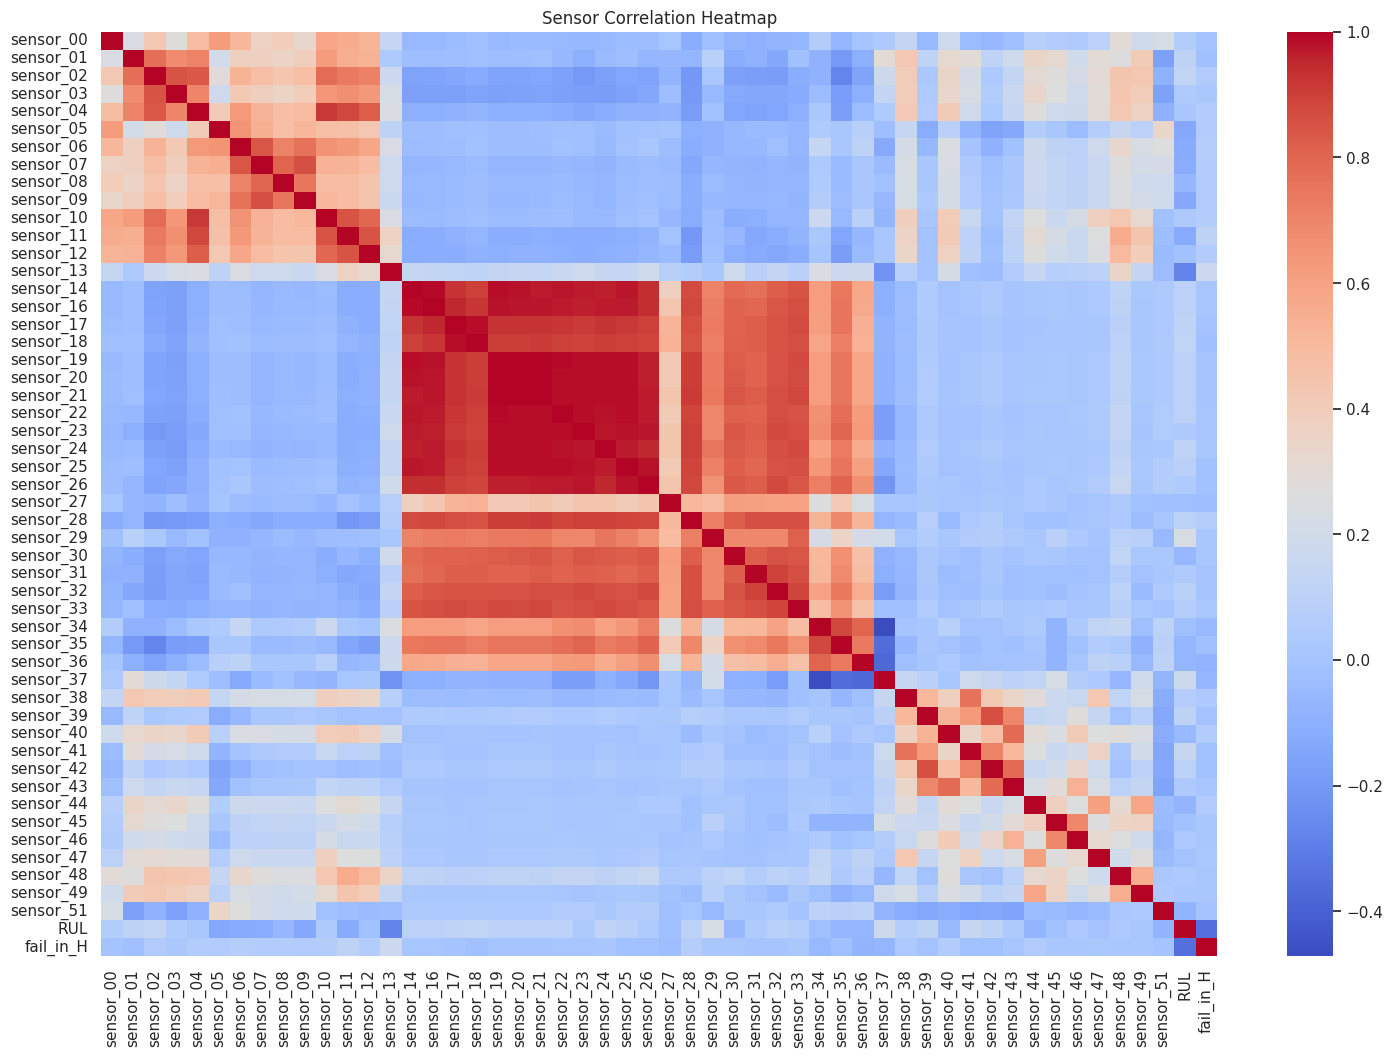

Top correlations with RUL: RUL          1.000000
fail_in_H   -0.347005
sensor_13   -0.276943
sensor_29    0.225014
sensor_37    0.177172
sensor_41    0.143912
sensor_05   -0.136829
sensor_09   -0.134840
sensor_02    0.123011
sensor_11   -0.122571
sensor_06   -0.122301
sensor_07   -0.118587
sensor_18    0.117584
sensor_17    0.113857
sensor_24    0.112879
Name: RUL, dtype: float64


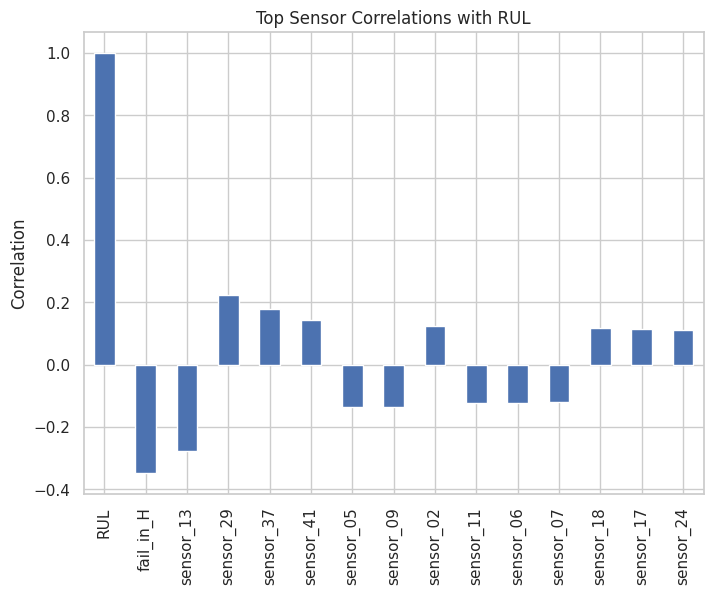

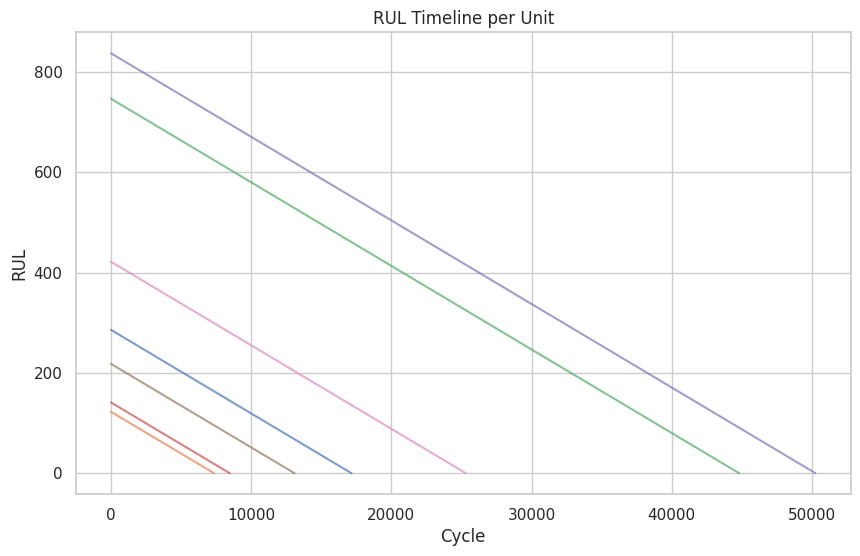

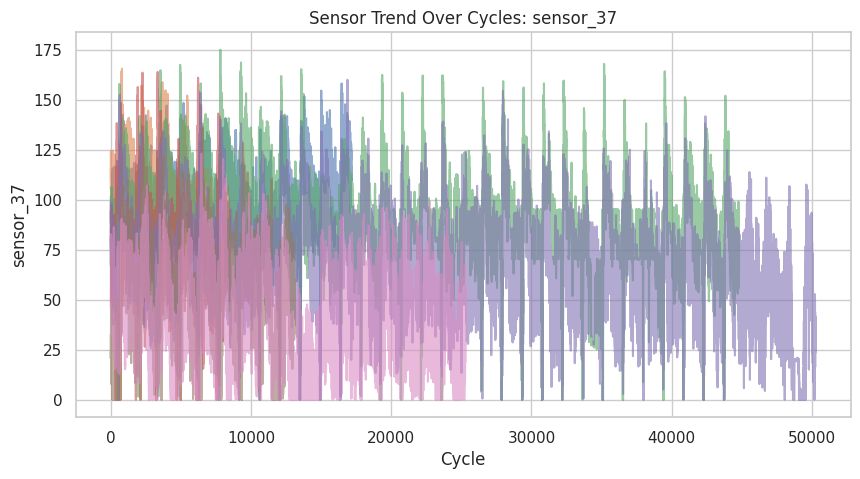

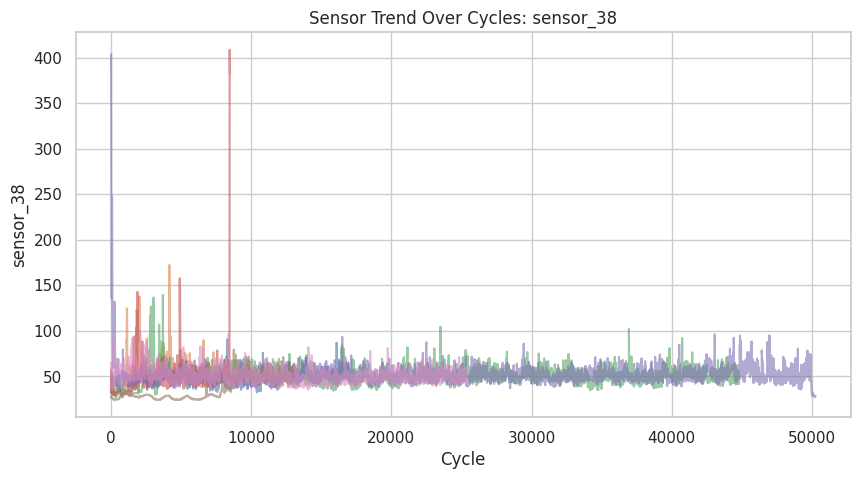

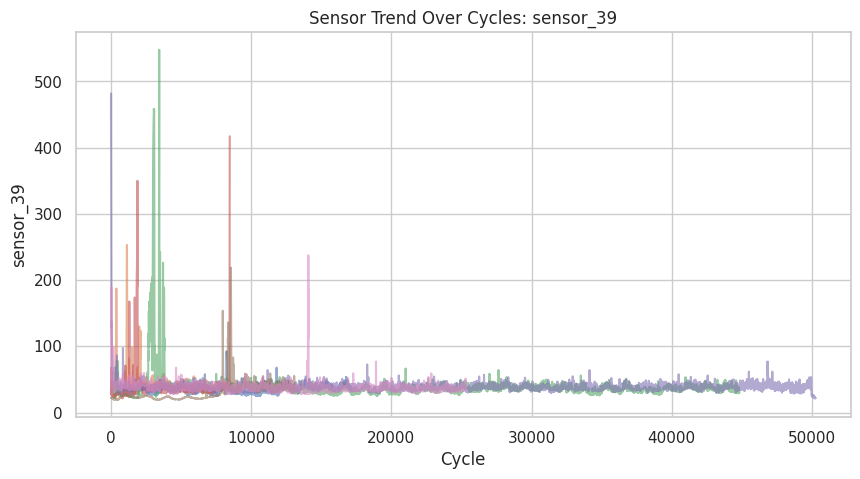

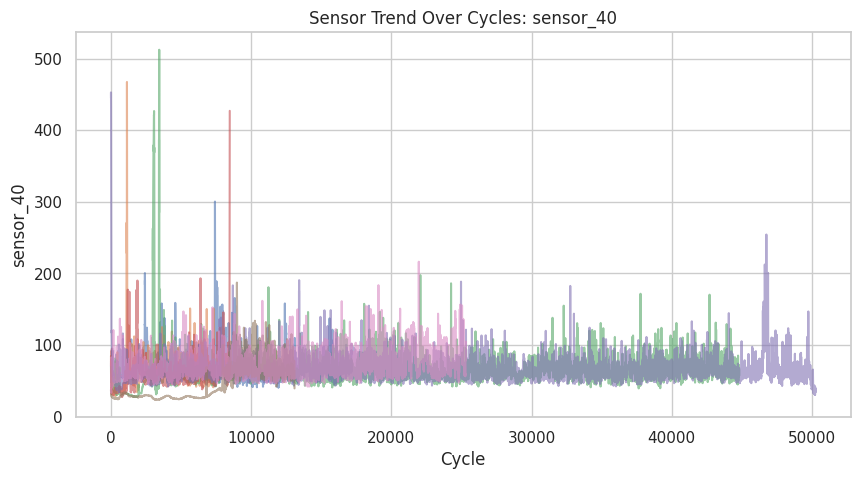

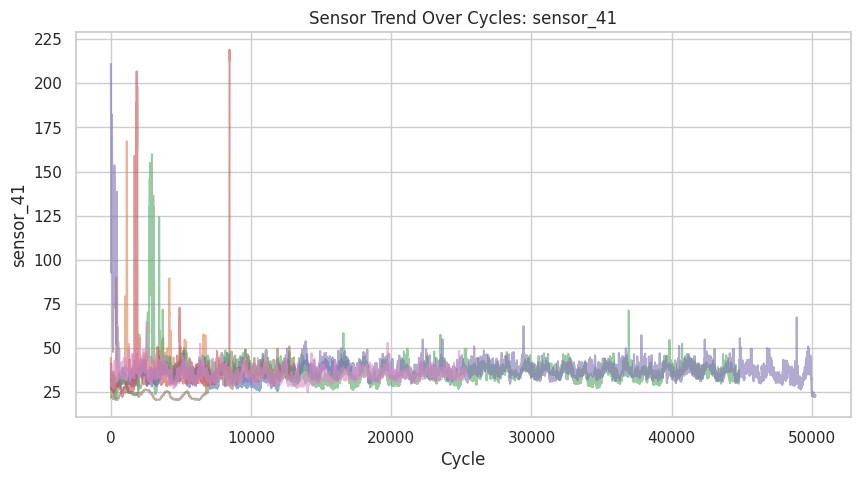

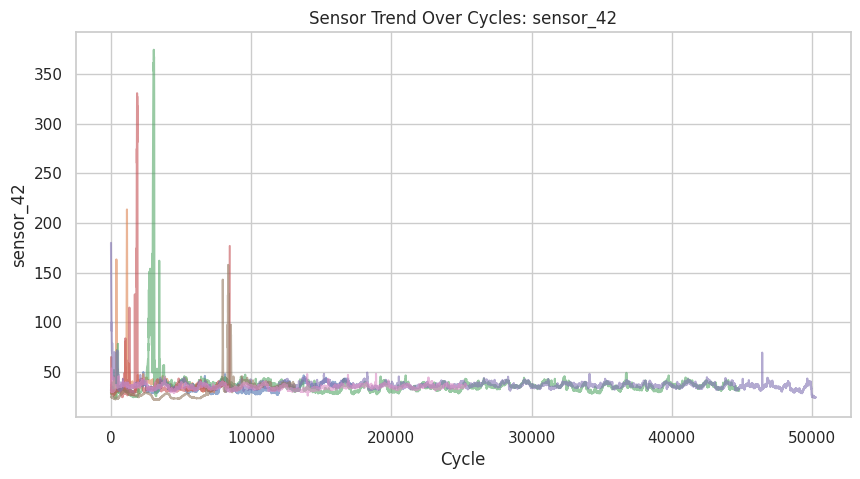

<Axes: >

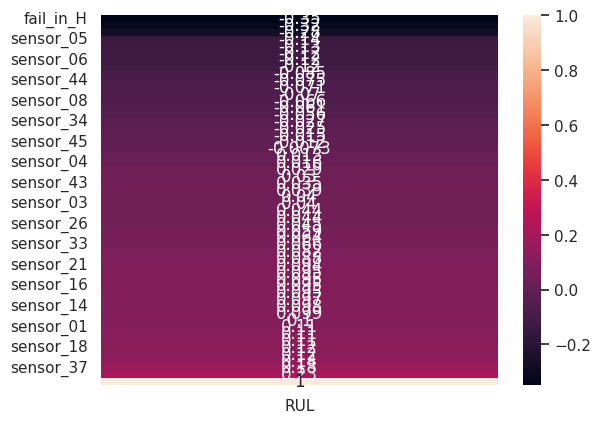

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import drive

sns.set(style='whitegrid')

# Mount & load
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')
else:
    print('Drive already mounted!')

PREP_IN = '/content/drive/MyDrive/dsp-poc/data/df_preprocessed.parquet'
df = pd.read_parquet(PREP_IN)
print('Loaded preprocessed:', df.shape)

# Identify sensor columns
exclude_cols = ['RUL', 'unit', 'cycle', 'fail_in_H']
sensor_cols = [c for c in df.columns if c not in exclude_cols]

# Missing heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False)
plt.title('Missing Value Heatmap')
plt.show()

# RUL distribution & boxplot
plt.figure(figsize=(8,5))
sns.histplot(df['RUL'], kde=True, bins=40)
plt.title('RUL Distribution')
plt.xlabel('RUL')
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x=df['RUL'])
plt.title('RUL Boxplot')
plt.show()

# Failure class countplot
plt.figure(figsize=(6,4))
sns.countplot(x=df['fail_in_H'])
plt.title('Failure Class Distribution (fail_in_H)')
plt.xlabel('Fail within H cycles? (0/1)')
plt.show()

#RUL vs Failure Class
plt.figure(figsize=(8,5))
sns.boxplot(x="fail_in_H", y="RUL", data=df)
plt.title("RUL vs Failure Class")
plt.show()


sensor_cols_sample = sensor_cols[:12]
df[sensor_cols_sample].hist(figsize=(18,12), bins=40)
plt.suptitle("Sensor Histograms", fontsize=16)
plt.show()

sensor_cols_sample = sensor_cols[12:24]
df[sensor_cols_sample].hist(figsize=(18,12), bins=40)
plt.suptitle("Sensor Histograms", fontsize=16)
plt.show()

sensor_cols_sample = sensor_cols[24:36]
df[sensor_cols_sample].hist(figsize=(18,12), bins=40)
plt.suptitle("Sensor Histograms", fontsize=16)
plt.show()

sensor_cols_sample = sensor_cols[36:]
df[sensor_cols_sample].hist(figsize=(18,12), bins=40)
plt.suptitle("Sensor Histograms", fontsize=16)
plt.show()


# Correlation heatmap
corr = df[sensor_cols + ['RUL', 'fail_in_H']].corr()
plt.figure(figsize=(18,12))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Sensor Correlation Heatmap')
plt.show()

# Top correlations with RUL
corr_rul = corr['RUL'].sort_values(key=lambda s: s.abs(), ascending=False).head(15)
print('Top correlations with RUL:', corr_rul)
plt.figure(figsize=(8,6))
corr_rul.plot(kind='bar')
plt.title('Top Sensor Correlations with RUL')
plt.ylabel('Correlation')
plt.show()

# RUL timeline per Unit
plt.figure(figsize=(10,6))
for u, g in df.groupby("unit"):
    plt.plot(g["cycle"], g["RUL"], alpha=0.7)
plt.title("RUL Timeline per Unit")
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.show()

#Sensor Trend over cycles
for col in sensor_cols_sample[:6]:
    plt.figure(figsize=(10,5))
    for u, g in df.groupby("unit"):
        plt.plot(g["cycle"], g[col], alpha=0.6)
    plt.title(f"Sensor Trend Over Cycles: {col}")
    plt.xlabel("Cycle")
    plt.ylabel(col)
    plt.show()

# Correlation with RUL (RUL column heatmap)
sns.heatmap(df.corr()[['RUL']].sort_values(by='RUL'), annot=True)



# Histogram Analysis
Shape:

Strong right-skew: Most observations are concentrated at low RUL values (0–150), then gradually taper off toward 800+.
Indicates machines are often near end-of-life when sampled.
Density Peaks:

Highest frequency between 0–150 RUL, suggesting many machines are close to failure.
Fewer samples at high RUL → potential data imbalance for regression and classification.
Tail Behavior:

Long tail up to ~850 RUL → rare cases of machines far from failure.
Implications:

Regression models may underpredict high RUL due to sparse data in that region. Classification for “Fail-in-H” (≤30 hours) will be imbalanced (~7.6% positives)
# Boxplot Analysis
Median:

Around 200–220 RUL, confirming most machines are closer to failure than mid-life.
IQR (Interquartile Range):

Roughly 150–400 RUL, showing moderate spread among typical cases.
Suggests variability in mid-life machines.
Whiskers:

Lower whisker near 0, upper whisker extends toward 800, confirming right-skew.
Indicates presence of high-RUL outliers.
Outliers:

Points beyond ~800 RUL are rare but exist; these are extreme long-life machines.
For regression, these can inflate RMSE; consider robust metrics or quantile regression.
Implications:

Models trained on this distribution will be biased toward low/mid RUL.
Validate predictions across bins (e.g., 0–30, 31–200, 201–500, >500) to ensure fairness.

# Failure Class Distribution - (fail_in_H countplot)


**Class imbalance:**
*   The plot shows a heavy skew toward class 0 (no failure within H cycles) versus a much smaller bar for class 1.
*   From earlier counts: 0 ≈ 153,834 vs 1 ≈ 12,607 (~7.6% positives).

**Interpretation**
*   The dataset contains far more healthy snapshots than imminent-failure snapshots.
*   Any classifier trained here will naturally see more negative samples and may tend to predict 0 unless calibra

**Visual cues:**
*   The sizeable height difference confirms that imminent failures are rare events compared to non-failures.

# RUL vs Failure Class (boxplot by fail_in_H)

Class 0 (no failure within H)
*   Median RUL is high (visually around a few hundred).
*   Wide IQR (box height), showing large variation in remaining life among non-failure snapshots.
*   Upper whisker extends toward very high RUL values (long-life machines).


Class 1 (failure within H)
*   Median RUL is very low (visually in the tens).
*   Narrow IQR—these samples are tightly clustered near the horizon threshold.
*   Whiskers are short; very few high-RUL outliers (as expected for imminent failures).

Interpretation
*  The separation between boxes is strong and intuitive: low RUL corresponds to fail_in_H=1, high RUL to fail_in_H=0.
*   Despite clear separation, the class 0 box shows overlap with low RUL values (lower whisker), meaning some non-failure rows still have relatively small RUL (but remain above H).



# Sensor Correlation Heatmap

**Block structures (clusters)**
*   A prominent red block (high positives) around sensor_14–sensor_33 reveals a group of strongly co‑varying sensors.

*   Smaller correlated groups appear in the early indices (e.g., sensor_00–sensor_05) and around sensor_37–sensor_41.

**Redundancy**
*   Within each block, many sensors are highly correlated, indicating redundant information—likely measuring related physical processes or derived transformations.

**Mixed signs:**
*   Outside clusters, numerous light blues/oranges suggest modest negative/positive correlations across unrelated sensors.

**Targets**
*   RUL and fail_in_H sit at the bottom; fail_in_H visually shows negative association with RUL (consistent with logic: imminent failure ↔ low RUL).

**Interpretation:**
*   The data exhibits latent structure (subsystems/regimes).
*   The lack of one single dominant global correlation to RUL implies multivariate patterns matter more than any individual sensor.





# Top Sensor Correlations with RUL (bar chart + listing)


**Signs & magnitudes**
*   fail_in_H: −0.3478 (strongest association by design—lower RUL ↔ class 1).

*  sensor_13: −0.2769 (higher sensor_13 ↔ lower RUL).

*   sensor_29: +0.2256 (higher sensor_29 ↔ higher RUL).

*   sensor_37: +0.1771, sensor_41: +0.1439 (moderate positive associations).
*   Several others in the ±0.11–0.14 range (e.g., sensor_05, sensor_09 negative; sensor_02, 11, 86, 07, 18, 17, 24 positive).

**Interpretation of signs**
*   Negative correlation → sensor increases as RUL decreases (possible wear/strain indicators).
*   Positive correlation → sensor increases as RUL increases (possible health/efficiency indicators).

**Magnitude context**
*   Most correlations are modest (|ρ| ≤ ~0.28).
*   This suggests no single sensor explains RUL well alone; combinations and non-linear interactions drive predictive power.

**Consistency check:**
*   The bar chart visually corroborates the listing: fail_in_H strongly negative (by construction), sensor_13 negative, sensor_29/37/41 positive.



# RUL Timeline per Unit


*   Linear decay: Each unit’s line is straight and descending to zero → RUL decreases linearly with cycle count.

*   Different slopes/lengths: Units have different starting RULs and lifespans (some up to 50k cycles), indicating heterogeneous operating durations.
*   No interruptions: Lines are continuous—no resets—suggesting a clean synthetic/derived RUL trajectory per unit.


*   **Takeaway**: Strong confirmation of our earlier assumption—7 units with linear RUL decay; good for time-aware views, even though we are treating rows as independent snapshots for modeling.



# Sensor Trend Over Cycles (per sensor across all units)
**sensor_00**



*   Plateau behavior: Long stretches near ~2.4 (flat), then abrupt collapses near end-of-life for long-lived units.

*  Early transients: Short units show early dips before stabilizing.
*  Takeaway: Behaves like a saturation metric with event drops late in life.

**sensor_01**
*  Stabilization: After early variability, series stabilizes around ~46–50.



*  Minor drift: Long unit shows slight downward drift late, but still small relative to noise.
*   Takeaway: Weak trend; largely stationary with noise.


**sensor_02**
*  Early regime shift: Some units have low initial values rising to ~50–55, then stabilize.

*  Late cycles: Long unit exhibits gradual soft decline.

*   Takeaway: Mix of initial transient then mild trend; not strongly monotonic.

**sensor_03**
*   Stable band: Values hover ~43–46 with sporadic dips.
*   Unit variability: Different units occupy slightly different bands, suggesting unit-specific baselines.

*   Takeaway: Stationary with unit-dependent offset; event dips occur.

**sensor_04**
*   High steady baseline: Most of the time at ~630–650.
*   Takeaway: Event‑driven sensor with rare extremes; useful for anomaly/event detection.

**sensor_05**
*   Early volatility: High variance ~60–100 initially.
*   Slow drift: For long unit, gradual downward drift with late-cycle spikes and one near-zero collapse at the end.


*  Takeaway: Shows progressive degradation tendency plus late anomalies; aligns with negative association to failure.








# Correlation with RUL (RUL column heatmap sorted)



*   fail_in_H is strongly negative with RUL (≈ −0.35).

*   Top negatives: sensor_13 (~ −0.277), sensor_05 (~ −0.135), sensor_09 (~ −0.134) → increase as RUL decreases (wear/strain type).

*   Top positives: sensor_29 (~ +0.226), sensor_37 (~ +0.177), sensor_41 (~ +0.144) → increase as RUL increases (health/efficiency type).

*   Most sensor–RUL correlations are modest (|ρ| ≤ ~0.28), implying multivariate, non-linear relationships dominate.

*   **Takeaways**: No single sensor explains RUL well alone; combinations matter, which is very consistent with our multivariate plots.





# Summarizing the EDA done so far


*   our RUL is right-skewed with few high-RUL cases; classification for fail-in-H is highly imbalanced.
*   Sensors exhibit clusters and unit-specific baselines, with modest correlations to RUL—no single sensor dominates; events (drops/spikes) in several sensors increase near failure.
*   to leverage per‑unit sequences, the linear RUL decay and late sensor events make sequence models promising.
